# Check topical span of editwars

## Load data

In [1]:
import pandas as pd
import networkx as nx

G = nx.read_gpickle("WikiProjectGraphNetworkx.pickle")

In [8]:
df = pd.read_csv('revs_2017_users_more_than_10_revs.txt.gz',sep='\t')

In [9]:
pages = df['rev_page'].unique()
del df

In [10]:
import json
with open('namespaces.json') as f:
    namespaces = json.load(f)

In [ ]:
import json,gzip
pagesToWikiprojectsDF = pd.read_csv('article2Wikiproject.txt.gz',sep='\t')
pagesToWikiprojects = {}
n = 0
for index,row in pagesToWikiprojectsDF.iterrows():
        if n % 100000 ==0: print(n)
        n+=1
        pagesToWikiprojects[row['page_id']] = row['projects'].split(',')
del pagesToWikiprojectsDF

In [4]:
#import json
#with open('pagesToWikiprojects.json','w') as f:
    #json.dump(pagesToWikiprojects,f)

#uncomment to load
with open('pagesToWikiprojects.json') as f:
    pagesToWikiprojects  = json.load(f)

## Define Topic Distance metrics

In [5]:
from itertools import combinations
from itertools import product

def distanceProjects(Graph,listProjects):
    if len(listProjects) > 1:
        results = []
        for x,y in combinations(listProjects,2):
            results.append(nx.shortest_path_length(Graph,x,y))
        return min(results),max(results),sum(results)/len(results)
    else:
        return 0   

In [6]:
def distancePages(Graph,page1,page2):
    """
    return -2 if error  (page without wikiproject)
    return -1 if the two pages are the same
    else
    return shortest path
    """
    global pagesToWikiprojects
    results = []
    if page1==page2:
        return -1   
    try:
        pages1Projects = pagesToWikiprojects.get(page1,[])
        pages2Projects = pagesToWikiprojects.get(page2,[])
    except:
        return -2
    for x,y in product(pages1Projects,pages2Projects):
        try:
            results.append(nx.shortest_path_length(Graph,x,y))
        except:pass
    if not results:
        return -2
    else:
        return min(results)

## Check topical span within an article (each article can belong to more than one wikiproject)

In [11]:
withinPages = {'max':[],'min':[],'avg':[]}
for n,page in enumerate(pages):
    n+=1
    if n%1000000 == 0: print(n)
    try:
        minD,maxD,avgD  = distanceProjects(G,pagesToWikiprojects[page])
        withinPages['max'].append(maxD)
        withinPages['min'].append(minD)
        withinPages['avg'].append(avgD)
    except:
        pass



1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000


In [12]:
import numpy as np
from scipy import stats

print('max',np.mean(withinPages['max']),stats.mode(withinPages['max'])[0])
print('min',np.mean(withinPages['min']),stats.mode(withinPages['min'])[0])
print('avg',np.mean(withinPages['avg']),stats.mode(withinPages['avg'])[0])


max 6.03269895356 [8]
min 4.39872249077 [2]
avg 5.34156664011 [ 5.]


## Topics popularity

In [10]:
topicsPopularty = {}
noProject = []
noNamespace = []
for n,page in enumerate(pages):
    if str(page) in namespaces:
        if namespaces.get(str(page)) == 0:
            if page in pagesToWikiprojects:
                for project in pagesToWikiprojects[page]:
                    try:
                        topicsPopularty[project]+=1
                    except:
                        topicsPopularty[project]=1
            else:
                noProject.append(page)
    else:
        noNamespace.append(page)


print(sum(topicsPopularty.values()))
print(len(noProject))
print(len(noNamespace))


6168981
1791348
11540


In [109]:
print('Percentage of pages without recognized wikiproject ',len(noProject)/(sum(topicsPopularty.values()) + len(noProject) ) )

Percentage of pages without recognized wikiproject  0.22503441754731493


Note that this number refers to pages where our query https://quarry.wmflabs.org/query/23214] doesn't return a wikiproject. However, manually reviewing we found cases where the Wikiproject is not correctly (?) assigned as category in the Talk pages (example en:Classon_Avenue_(IND_Crosstown_Line) belongs to Wikiproject Trains, but that project is not listed as category). ** Future work **: Improve wikiproject to page retrival

In [15]:
sorted(topicsPopularty.items(), key=lambda x: x[1],reverse=True)[0:50]

[('WikiProject_Biography_articles', 1144535),
 ('WikiProject_United_States_articles', 237067),
 ('WikiProject_Football_articles', 189481),
 ('WikiProject_India_articles', 123567),
 ('WikiProject_Australia_articles', 119105),
 ('WikiProject_Film_articles', 113143),
 ('WikiProject_Albums_articles', 88987),
 ('WikiProject_Women_articles', 85922),
 ('WikiProject_Olympics_articles', 79904),
 ('WikiProject_Disambiguation_pages', 78454),
 ('WikiProject_Iran_articles', 68911),
 ('WikiProject_Television_articles', 67315),
 ('WikiProject_Geography_articles', 66089),
 ('WikiProject_Poland_articles', 63383),
 ('WikiProject_Africa_articles', 55175),
 ('WikiProject_College_football_articles', 46080),
 ('WikiProject_Japan_articles', 44943),
 ('WikiProject_Russia_articles', 39559),
 ('WikiProject_Elections_and_Referendums_articles', 37742),
 ('WikiProject_French_communes_articles', 37335),
 ('WikiProject_California_articles', 36914),
 ('WikiProject_Aviation_articles', 36550),
 ('WikiProject_China_arti

## Check topical span of edit wars (pair of users where one has reverted more than 3 times another)

In [8]:
import json
with open('interactions.json') as f:
    interactions = json.load(f)
print(len(interactions))

47307


In [ ]:
editWars = {}
n=0
for user1, user2dict in interactions.items():
    n+=1
    if n % 1000 ==0: print(n)
    editWars[user1] = {}
    for user2,reverts in user2dict.items():
        if (user1 != user2) and (len(reverts) >2):
            pages = [page for page,timestamp,delta,reverting_id,revered_id in reverts]        
            distances = []
            for page1,page2 in combinations(pages,2):
                    minD = distancePages(G,page1,page2)
                    distances.append(minD)
            editWars[user1][user2] = (distances)
    if not editWars[user1]: del editWars[user1]

In [ ]:
with open('editWarsDistance.json','w') as f:
    json.dump(editWars,f)

editWarsDistance.json is dictionary where each entry represents the topic distance between all the pages where a user X reverted user Y

Example: 
    editWarsDistance[UserA] = {userB:[-1,-1,0],userC:[1,2,-1]}
    
    Means that userA has reverted user B, and C, and the values on the list respresent the topic distance between all tha pair of pages. 
    

In [15]:
with open('editWarsDistance.json') as f:
    editWars = json.load(f)

### Add here frecuency analyzis of reverts
* Compute mode of reverts

In [16]:
from scipy import stats

revertsDistanceMode = []
for user1,data in editWars.items():
        for user2,distances in data.items():
            cleanDistances = [ x for x in distances if x != -2] #remove -2, pages without wikiproject
            if cleanDistances:
                revertsDistanceMode.append(stats.mode(cleanDistances).mode[0])


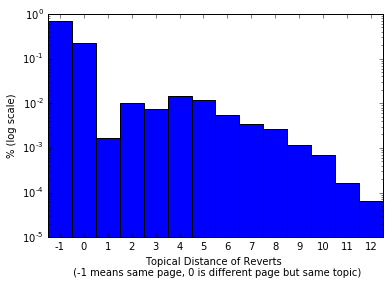

|-
| -1 || 0.7107
|-
| 0 || 0.2297
|-
| 4 || 0.0143
|-
| 5 || 0.0121
|-
| 2 || 0.0103
|-
| 3 || 0.0074
|-
| 6 || 0.0056
|-
| 7 || 0.0034
|-
| 8 || 0.0027
|-
| 1 || 0.0016
|-
| 9 || 0.0012
|-
| 10 || 0.0007
|-
| 11 || 0.0002
|-
| 12 || 0.0001


In [17]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

count = Counter(revertsDistanceMode)

labels, values = zip(* sorted([(int(x),y/len(revertsDistanceMode)) for x,y in count.items()]))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.yscale('log')
plt.xlabel('Topical Distance of Reverts \n (-1 means same page, 0 is different page but same topic)')
plt.ylabel('% (log scale)')
plt.savefig("modeDistanceOfReverts.png")

plt.show()

for x, y in count.most_common(15):
    print ("|-")
    print("| %s || %s" % (x,round(y/len(revertsDistanceMode),4)))



# edtior focus 

In [22]:
import pandas as pd
df = pd.read_csv('revs_2017_users_more_than_10_revs.txt.gz',sep='\t')

### 'Jumping' across topics ?
UserDistance[userX] represent the sequence of topic 'jumps' in the next edition from userX. 

In [23]:
#with open('namespaces.json') as f:
#    namespaces = json.load(f)
# THIS PROCESS MIGHT TAKE TIME.
from itertools import combinations
userDistance = {}
n = 0
for user, data in df[['rev_page','rev_user','rev_timestamp']].sort_values('rev_timestamp').groupby("rev_user"):
    if n %10000 ==0: print(n)
    n+=1
    revs = [x for x in  data['rev_page']  if namespaces.get(x,False) == 0]
    distance = []
    for page1, page2 in zip(revs,revs[1:]):
        distance.append(distancePages(G,page1,page2))
    userDistance[user] = distance

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000


In [26]:
userDistanceEncoded = {}
for user,data in userDistance.items():
    userDistanceEncoded[str(user)] = data
with open('userDistance.json','w') as f:
    json.dump(userDistanceEncoded,f)

In [11]:
with open('userDistance.json') as f:
    userDistance =json.load(f)

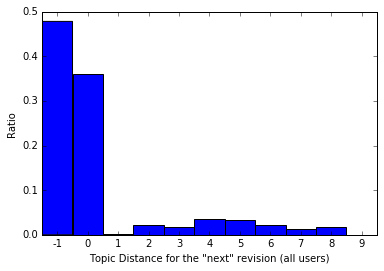

In [33]:
import itertools
plt.close()
tmp =list(itertools.chain(*userDistance.values()))
plt.hist(tmp,bins=list(range(-1,10)),normed=1)
plt.xlim([-1,10])
plt.ylim([0,0.5])
plt.xticks( [ x+0.5 for x in list(range(-1,10))], list(range(-1,10)))
plt.ylabel('Ratio')
plt.xlabel('Topic Distance for the "next" revision (all users)')

plt.show()

### Finding Probability of Jumping per user

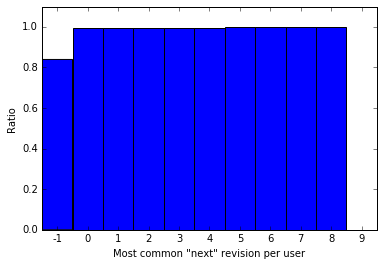

In [103]:
from collections import Counter
jumpingProbability = {}
mostFrequentPerUser = []
for user, distances in userDistance.items():
    jumpingProbability[user] = [ (distance,freq/len(distances)) for distance,freq in  Counter(distances).items()]
    mostFrequentPerUser.append(Counter(distances).most_common(1)[0][0])
plt.close()
plt.hist(mostFrequentPerUser,bins=list(range(-1,10)),normed=1,cumulative=1)
plt.xlim([-1,10])
plt.ylim([0,1.1])
plt.xticks( [ x+0.5 for x in list(range(-1,10))], list(range(-1,10)))
plt.ylabel('Ratio')
plt.xlabel('Most common "next" revision per user')
plt.show()
mostFrequentPerUser.most_common()

In [109]:
plt.hist(mostFrequentPerUser,bins=list(range(-1,10)),normed=1,cumulative=1)


(array([ 0.8395282 ,  0.99246454,  0.99256184,  0.99355648,  0.99430246,
         0.99685392,  0.998854  ,  0.99938376,  0.99963242,  1.        ]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]),
 <a list of 10 Patch objects>)

Here we see that 83.95% of users usually has their next revision on the same page, and 99.25% on the same topic. 

#### Longest 'jump' per user

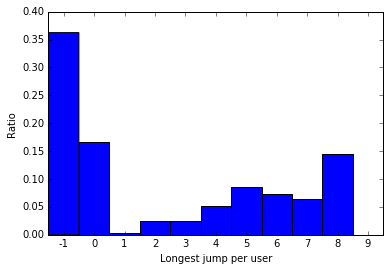

In [113]:
from collections import Counter
longest = []
for user, distances in userDistance.items():
    longest.append(max(distances))
plt.close()
plt.hist(longest,bins=list(range(-1,10)),normed=1)
plt.xlim([-1,10])
plt.ylim([0,0.4])
plt.xticks( [ x+0.5 for x in list(range(-1,10))], list(range(-1,10)))
plt.ylabel('Ratio')
plt.xlabel('Longest jump per user')
plt.show()


In [114]:
plt.hist(longest,bins=list(range(-1,10)),normed=1,cumulative=1)


(array([ 0.36233049,  0.52880117,  0.53276033,  0.55703131,  0.58120923,
         0.63221298,  0.71876454,  0.79161979,  0.85592224,  1.        ]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]),
 <a list of 10 Patch objects>)

In [115]:
plt.hist(longest,bins=list(range(-1,10)),normed=1,cumulative=-1)


(array([ 1.        ,  0.63766951,  0.47119883,  0.46723967,  0.44296869,
         0.41879077,  0.36778702,  0.28123546,  0.20838021,  0.14407776]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]),
 <a list of 10 Patch objects>)

52.88% of users never jump  out of the same topic, but 41.88% jumps more than 4 steps

# Cross-topic edit wars

As seen before, there around 71% of the reverts on edit wars occurs in only one page, and 93% on the same topic. 
Here we study the ~7% of edit wars across topic topics

In [9]:
#with open('editWarsDistance.json') as f:
#    editWars = json.load(f)
with open('usersPercentOfReverts.json') as f:
    usersPercentOfReverts = json.load(f)

In [18]:
crossTopicEditWars = {}
for user1, info in editWars.items():
    for user2,distances in info.items():
        if max(distances) > 0:
            crossTopicEditWars[user1] = crossTopicEditWars.get(user1,{})
            crossTopicEditWars[user1][user2] = distances

In [151]:
### Check bots

In [19]:
with open('user_posibleBots.json') as f:
    bots = set(json.load(f))
print(len(crossTopicEditWars.keys() & bots))

26


In [20]:
for bot in bots & crossTopicEditWars.keys():
    del(crossTopicEditWars[bot])

In [21]:
revertedBots = {}
for user1,info in crossTopicEditWars.items():
    for bot in  info.keys() & bots:
        revertedBots[bot] = revertedBots.get(bot,0)
        revertedBots[bot] += 1
        del(crossTopicEditWars[user1][bot])

In [155]:
revertedBots

{'1215485': 2,
 '12406635': 1,
 '1310918': 1,
 '13286072': 349,
 '14394459': 1,
 '14508071': 5,
 '15270283': 1,
 '15449111': 3,
 '15996738': 2,
 '16266655': 3,
 '16283967': 1,
 '16752040': 2,
 '17216044': 13,
 '20611691': 9,
 '24649005': 9,
 '24684472': 54,
 '27015025': 30,
 '27446209': 7,
 '27823944': 7,
 '279219': 8,
 '28481209': 1,
 '28903366': 6,
 '29463730': 2,
 '30589160': 1,
 '30707369': 4,
 '31197275': 1,
 '31691822': 8,
 '31737083': 1,
 '31738379': 1,
 '32237108': 1,
 '4773966': 1,
 '4851336': 3,
 '6163802': 5,
 '7611264': 274,
 '7903804': 7,
 '9021902': 1,
 '9536040': 1}

In [28]:
#getting the total number of users (c) and pair of users (total)
c = 0
pairs = 0
totalUsers = {}
for user1,info in crossTopicEditWars.items():
    pairs +=len(info)
    if len(info) > 1: 
        c+=1
    totalUsers[user1] = {}
    for user2 in info.keys():
        totalUsers[user2] = {}
   
   
print(c,pairs,len(totalUsers))

840 6648 5759


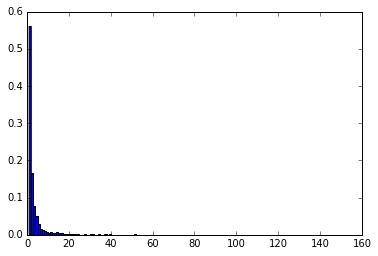

148


In [158]:
plt.close()
warsPerUser = [len(x) for x in  crossTopicEditWars.values()]
plt.hist(warsPerUser,bins=list(range(1,max(warsPerUser))),normed=1)
plt.show()
print(max(warsPerUser))

## Number of users Reverted Comparison 


In [23]:
with open('numberOfUsersReverted.json') as f:
    numberOfUsersReverted = json.load(f)

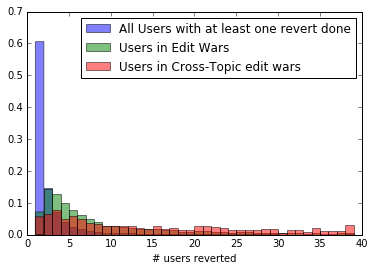

In [181]:
plt.close()
plt.hist(list(numberOfUsersReverted.values()),bins=list(range(1,40)),normed=1,  alpha=0.5, label='All Users with at least one revert done')
plt.hist([numberOfUsersReverted[user] for user in editWars.keys()],bins=list(range(1,40)),normed=1,  alpha=0.5, label='Users in Edit Wars')
plt.hist([numberOfUsersReverted[user] for user in crossTopicEditWars.keys()],bins=list(range(1,40)),normed=1,  alpha=0.5, label='Users in Cross-Topic edit wars')
plt.xlabel('# users reverted')
plt.legend(loc='upper right')
plt.show()

In [185]:
revertingLessThanTenUsers = [ user for user in crossTopicEditWars.keys() if numberOfUsersReverted[user] <10 ]

In [186]:
len(revertingLessThanTenUsers)

492

### Activity Comparison

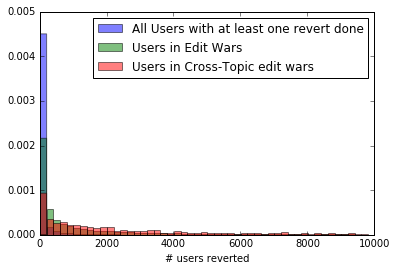

In [108]:
plt.close()
bins = list(range(10,10000,200))
plt.hist(list(revsPerUser.values()),bins=bins,normed=1,  alpha=0.5, label='All Users with at least one revert done')
plt.hist([revsPerUser[user] for user in editWars.keys()],bins=bins,normed=1,  alpha=0.5, label='Users in Edit Wars')
plt.hist([revsPerUser[user] for user in crossTopicEditWars.keys()],bins=bins,normed=1,  alpha=0.5, label='Users in Cross-Topic edit wars')
plt.xlabel('# users reverted')
plt.legend(loc='upper right')
plt.show()


In [105]:
max(revsPerUser.values())

1276038

### Topical Behavior of users involved in cross-topic edit wars

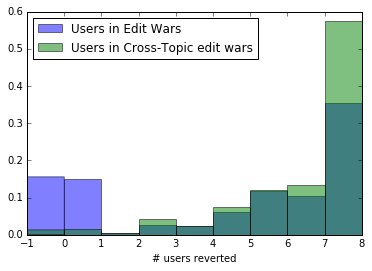

In [43]:

plt.close()
allUsersDistance =list([max(d) for d in userDistance.values()])
editWarsDistance =list([max(userDistance[user]) for user in  editWars.keys()])
crossTopicDistance =list([max(userDistance[user]) for user in  crossTopicEditWars.keys()])

#plt.hist(allUsersDistance,bins=list(range(-1,9)),normed=1,  alpha=0.5, label='All Users with at least one revert done')
plt.hist(editWarsDistance,bins=list(range(-1,9)),normed=1,  alpha=0.5, label='Users in Edit Wars')
plt.hist(crossTopicDistance,bins=list(range(-1,9)),normed=1,  alpha=0.5, label='Users in Cross-Topic edit wars')
plt.xlabel('# users reverted')
plt.legend(loc='upper left')
plt.show()
plt.show()

# TODO compare the probability onf posting in a given topic



In [7]:
df = pd.read_csv('revs_2017_users_more_than_10_revs.txt.gz',sep='\t')

In [24]:
crossTopicUsersList = totalUsers.keys()
crossTopicUsersActivity = df[df['rev_user'].isin(crossTopicUsersList)]

In [26]:
del df

In [31]:
crossTopicUsersReverters = crossTopicUsersActivity[crossTopicUsersActivity['rev_user'].isin(list(crossTopicEditWars.keys()))]

In [32]:
crossTopicUsersReverters.shape

(11818037, 5)

In [ ]:
for user, data in crossTopicUsersReverters[['rev_page','rev_user','rev_timestamp']].sort_values('rev_timestamp').groupby("rev_user"):
    if n %100 ==0: print(n)
    n+=1
    revs = [x for x in  data['rev_page']  if namespaces.get(x,False) == 0]
    distance = []
    for page1, page2 in zip(revs,revs[1:]):
        distance.append(distancePages(G,page1,page2))
    userDistance[user] = distance